# CXR Audit  
This notebook contains the code for automating the grading of chest X-ray reports using two complementary approaches.

Large Language Models (LLMs) have been increasingly employed in radiology for diverse tasks, notably semantic information extraction and the generation of structured radiology reports. Traditionally, radiology reports undergo manual classification post-interpretation into broad categories such as normal, abnormal, and critical, which guide subsequent clinical management. Building upon these capabilities, this study aims to investigate the application of LLMs for automated grading of chest X-ray reports into these clinically relevant categories. By leveraging LLMs in this capacity, we seek to streamline radiological workflow processes, alleviate the cognitive burden on radiologists, and enhance the consistency of follow-up recommendations. Although vision-language models (VLMs) and convolutional neural network (CNN)-based computer vision approaches show promise in the direct interpretation of imaging studies, current clinical practice predominantly relies on human-in-the-loop reporting to ensure diagnostic accuracy and safety. Our approach endeavors to preserve the advantages of human oversight while automating a critical step in the reporting pipeline—report categorization—whose failure may lead to significant clinical consequences.

## The Methods

The first method, a semi-LLM algorithmic method, extracts structured findings from reports, then assigns priorities accordingly.  
The second method leverages a LLM to directly grade reports. 

## Our Goal  
To grade CXRs by the following grading scheme  

>   
> Grading (R):
> 1 = normal without any findings
> 2 = normal variant or minor pathology, does not require follow up
> 3 = abnormal, non-urgent follow-up required
> 4 = abnormal, potentially important finding
> 5 = critical, urgent follow-up required
>   
(Note the revised grading from the prior version)
(Notably, this grading system is much less ambiguous, and similar to current or previous grading systems used by other institutions e.g. KTPH, Singhealth)

(From TTSH DDR Handbook)  
Grade 6 should be used for critical, life threatening findings, including:
- Pneumothorax
- Aortic dissection
- Mediastinal emphysema
- Pneumoperitoneum
- Portal venous air
- Dilated bowel loops
- Significant tube or line misplacement e.g. malpositioned NGT

Grade 6 should also be used unexpected, life-changing findings, including:
- New lesions that are suspicious for malignancy
- New fracture
- New large volume pleural effusions
- New aneurysm

In [ ]:
# Consider the following prompt
'''
You are well versed in medical terminology for Chest X Ray reports, and your task is to review the given report and grade the report on a scale of 1 to 6, to 1 decimal point.

You will do the above by

1. listing out findings
2. assigning if each findings requires any follow up and at which interval
3. give the grading by considering all findings

Enlarged heart size only needs follow up if other related changes.

Unfolded aorta, vascular calcifications, chronic bone findings, scarring changes do NOT need any follow up.
Benign findings also do NOT require follow up.
Patient rotation and suboptimal effort do NOT require follow up.

Pleural thickening and atelectasis can be followed up after months, unless otherwise qualified.

Potential infections and possible fluid overload or pulmonary congestion are always actionable within 1 week.
Any changes which have increased from before are actionable within 1 week.

Pneumoperitoneum, aortic dissection or pneumothorax of any size are critical emergencies! P1 remarks are also emergencies!

Grading:
1 = normal without any findings
2 = any findings which do not require follow up
3 = actionable from 2 months onwards
4 = actionable by 1 month
5 = actionable within 1 week
6 = immediate action required

Mainly use the highest grade of a finding, especially for grades 5 or 6.
You may use an average between grade (such as 2.5, 3.5 etc) for other grades.
'''

# Our task for this script
'''
First, we classify the list of reports into positive findings
- Pathological findings
    > Lung
    > Pleura
    > Heart
    > Mediastinum
    > MSK
    > Abdomen
- Tube and line findings (malpositioning)

Then whether the finding is new, better, worse or stable

Below is a sample of an X-ray report, enclosed in three backticks (```). Please generate a list of positive findings from the report, and whether the finding is new, better, worse or stable.
'''

'''
Notes:
- If the chronicity of a finding is not mentioned, follow the path of "new"
- If a finding is "probably" X, it should be considered as X
- Find any P1 and P2SMS findings
- Find either new or worsening findings - should be R5
- Better or stable findings should be downgraded by one grade? R3?
- Uncertain findings can be downgraded by one grade
- If the only finding is "heart size cannot be assessed", it should be R2
- If the only finding is suboptimal technique, it should be R2
- Unfolded aorta should be R2
    - Is this the only situation for R2?
- Any line present should be at least R4 (unless malpositioned)
    - NGT can be R4
    - Any other line should be at least R5 (because they're seen in critically ill pts)
    - Malpositioned lines are all R6 (P1)
'''

# Method 1: Semi-LLM, Semi-Algorithmic Approach  

This semi-algorithmic approach first uses an LLM to semantically extract structured data (a list of positive anatomical findings and any medical devices) from a chest X-ray report, based on predefined lists derived from the Padchest labels. The overall maximum priority for the report is computed as the highest of the priorities.

1. First we extract a list of findings from the report, and grade them according to:
    - Temporal: ['new', 'better', 'worse', 'stable', 'not mentioned']
        - If a finding is new, we upgrade its priority by 1
        - If a finding is stable/better, we downgrade its priority by 1
    - Uncertainty: ['certain', 'uncertain', 'not mentioned']
        - If a finding is uncertain (e.g. "possibly", "may represent", "could be", "cannot be excluded"), we downgrade its priority by 1
    - Misplaced tubes & lines automatically get P1.
2. Then we grade the findings/lines according to their respective priorities (e.g. pneumothorax is R6, consolidation is R5, scarring is R2).
    - Tubes and lines are mostly R5 as they are mostly seen in critically ill patients
    - The exception is chronic support lines like NGT and tracheostomy tube that are R3-4 as they can be reviewed one or more months later
3. We find the max priority of the report overall.
  
  
---
  
Prompt for semantic extraction of the findings:  

> ### Your Task
> Below is a sample of an X-ray report, enclosed in \<report\> tags. 
>   
> \<report\>  
> {sample_report}  
> \</report\>  
>   
> Please generate a list of positive findings from the report, and whether the finding is new, better, worse or stable.   
> Also, please specify if any medical devices (tubes & lines) are present in the report and their placement, whether it is satisfactory or malpositioned.  
> Medical devices should not be in "findings" but in "devices". If there is no medical device, please return an empty list for "devices_all" ([]).  
> Mastectomy, surgical clips and surgical plates should be considered as findings and not as medical devices.  
>   
> Please choose the finding from this list. \  
> Use only the term that best fits the finding. \  
> Do not return a finding that is not in this list. \  
> List all positive findings only. Negative findings should not be included.  
>   
> Here is the list of findings: {padchest_findings_str}  
>   
> Here is a list of medical devices (tubes & lines): {tubes_lines_findings_str}  
>   
> Here is a list of overarching diagnoses: {diagnoses_str}  
>   
> Here is a description of the parameters:  
> For the anatomical findings  
> - finding: Pathological finding mentioned in the report, using the list above. Do not return a finding that is not in this list. If you think the finding is not in this list, return the closest one from the list.  
> - location: Location of the finding, e.g. right lower zone  
> - system: System of the body where the finding is located -- Lung, Pleura, Heart, Mediastinum, MSK, Abdomen  
> - temporal: new, better, worse, stable or not mentioned  
> - uncertainty: certain, uncertain, not mentioned  
>   
> For the medical devices (tubes & lines)  
> - medical_device: Name of the tube/line, using the list above. Do not return a device that is not in this list.  
> - placement: Placement of the tube/line -- satisfactory, suboptimal (abnormal but no urgent action is required), malpositioned (urgent repositioning or removal is required) or not mentioned  
>   
> For the diagnoses  
> - diagnosis: Overarching diagnosis suggested in the report, using the list above. Do not return a diagnosis that is not in this list.  
>     - For example, if "...suggestive of infection" is mentioned, return "pneumonia" as the diagnosis.  
>     - For example, if "...may be related to infection" is mentioned, return "pneumonia" as the diagnosis.  
>     - For example, if "...malignancy cannot be excluded" is mentioned, return "malignancy" as the diagnosis.  
>     - For example, if "...P1 for..." is mentioned, return "P1" as the diagnosis.  
> - temporal: new, better, worse, stable or not mentioned  
>   
> ### Finer Points  
> If the heart size is not accurately assessed, this should NOT be considered as a finding.  
> If the only finding is that there is no consolidation or pleural effusion with no other findings, this should be considered as a normal report with no finding. \  
> Even if "no consolidation" or "no pleural effusion" is qualified, for example "no confluent consolidation", \  
> "no large pleural effusion" or "no frank pleural effusion" \  
> this should be considered as a normal report with no finding.  
> If a finding is "probably", "suggestive of", "likely" or any other similar phrase that indicates a low uncertainty, \  
> this should be considered as a finding with "certain" uncertainty.  
> If a finding is "possibly", "may represent", "could be", "cannot be excluded" \  
> or any other similar phrase that indicates a high uncertainty, this should be considered as a finding with "uncertain" uncertainty.  
> A rotated or suboptimally inspired film can be considered as "suboptimal study".  
> Findings written in pleural should be considered as singular (e.g. "pleural effusions" as "pleural effusion", "nodular opacities" as "nodular opacity", "granulomas" as "granuloma").  
> 
> If the report suggests the possibility of a diagnosis of pneumonia, infection, or suggests correlation with infective markers, this diagnosis should be raised.  
> If the report suggests the possibility of a diagnosis of tuberculosis, atypical infection or mycobacterial infection, this diagnosis should be raised.  
> If the report suggests the possibility of a tumour, malignancy, or neoplasm, this diagnosis should be raised.
>     - If a CT thorax was suggested for an opacity, the diagnosis is "malignancy".  
> If the reporting radiologist indicated at the end that the report is "P1", this diagnosis should be raised.  
>     - This can come in the format "P1 for X", or "Dr xx was informed at the time of reporting".  
>     
> If the report suggests that a diagnosis "cannot be excluded", it should be considered as a positive diagnosis.  
> If the report suggests that a diagnosis from the diagnoses list is "possible", it should be considered as a positive diagnosis.  
  

# Option 2: All-LLM Approach  
This approach just asks the LLM to grade the report directly, giving it some instructions.  
  
---  
  
Prompt used:  
  
> Below is a chest X-ray report, enclosed in \<report\> tags.  
> Please grade the report on a scale of 1 to 6, to 1 decimal point.  
> Return the highest grade of the findings in the report.  
>   
> Grading (R):  
> 1 = normal without any findings  
> 2 = normal variant or minor pathology, does not require follow up  
> 3 = abnormal, non-urgent follow-up required  
> 4 = abnormal, potentially important finding  
> 5 = critical, urgent follow-up required  
>   
> Grade 5 should be used for critical, life threatening findings, including:  
> - Pneumothorax  
> - Aortic dissection  
> - Mediastinal emphysema  
> - Pneumoperitoneum  
> - Portal venous air  
> - Dilated bowel loops  
> - Significant tube or line misplacement e.g. malpositioned NGT  
>   
> Grade 5 should also be used unexpected, life-changing findings, including:  
> - New lesions that are suspicious for malignancy  
> - New fracture  
> - New large volume pleural effusions  
> - New aneurysm  
>   
> Any finding that has significant clinical impact that is new or worsening should be graded as 4  
> (save for those to be graded as 2, as below).  
> If the chronicity of a finding is not mentioned, it should be considered as new.  
> If a finding is "probably" X, it should be considered as X.  
>   
> Enlarged heart size only needs follow up if other related changes.  
>   
> Unfolded aorta, vascular calcifications, chronic bone findings, lung scarring and an unfolded thoracic aorta do NOT need any follow up and should be graded as 2.  
> Benign findings also do NOT require follow up and should be graded as 2.  
> Patient rotation and suboptimal effort do NOT require follow up and should be graded as 2.  
> If there is suboptimal technique with no other finding, this should be graded as 2.  
>   
> Pleural thickening and atelectasis should be grade 3, unless otherwise qualified.  
>   
> Potential infection/consolidation and possible fluid overload or pulmonary congestion should be graded as 4.  
> Patchy opacities, airspace opacities and hazy opacities should be graded as 4 for new pneumonia/infection.  
> A small pleural effusion can be graded as 3, but significant ones (moderate/severe) should be graded as 4.  
> If the report suggests the possibility of a diagnosis of pneumonia, infection, or suggests correlation with infective markers, this should be graded as 4.  
> If the report suggests the possibility of a diagnosis of tuberculosis, atypical infection or mycobacterial infection, this should be graded as 4.  
>     - If the report suggests that tuberculosis is stable, this should be graded as 3.  
> If the report suggests the possibility of a tumour, malignancy, or neoplasm, this should be graded as 4.  
>     - If the report suggests that the tumour is stable, this should be graded as 3.  
> If the reporting radiologist indicated at the end that the report is "P1", this should be graded as 5.  
>     - This can come in the format "P1 for X", or "Dr xx was informed at the time of reporting".  
>   
> Any line present should be at least grade 3 (unless malpositioned, in which case it should be grade 6)  
>     - A nasogastric tube in a satisfactory position can be grade 3  
>     - Any other line should be at least grade 4 (because they're seen in critically ill pts)  
>     - Malpositioned lines are all grade 5.  
>   
> Please provide your answer in a valid JSON with the following format:  
> {  
>     "grade": float (1 to 5, to 1 decimal point)  
> }  
>   
> Please grade this CXR report:  
>   
> \<report\>  
> {cxr_report}  
> \</report\>


# Results Analysis

Now we can have a look at the results. 

In [3]:
# Imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

df_reports_overall = pd.read_csv('../data_audit/all_op_processed.csv')
# Remove rows with missing values in any of the three grading columns
df_clean = df_reports_overall.dropna(subset=['priority_manual', 'priority_algo', 'priority_llm'])

In [2]:
#####################################
### Plot the distribution of data ###
#####################################

# Plot the distribution of IP/OP
#df_clean['Admission_Type'] = df_clean['Admission_Type'].replace({'I': 1, 'O': 0})
# Plot the distribution as a pie chart
#df_clean['Admission_Type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
#plt.title('Distribution of IP/OP')
#plt.ylabel('')
#plt.show()

# Plot the distribution of the system of findings as a bar graph
import ast
from collections import Counter

df_with_findings = df_clean

# Function to parse a string representation of a list of dictionaries
def parse_findings(findings_str):
    try:
        # Try literal_eval first
        return ast.literal_eval(findings_str)
    except Exception:
        try:
            # If that fails, try json.loads (after replacing single quotes)
            return json.loads(findings_str.replace("'", '"'))
        except Exception as e:
            print(f"Could not parse findings: {e}")
            return []

# Assuming df_reports_overall has a 'report_findings' column
# that contains a string representation of a list of findings.
all_systems = []
for entry in df_with_findings['report_findings'].dropna():
    findings = parse_findings(entry)
    for find in findings:
        # Expect each finding to be a dict with a "system" key.
        if isinstance(find, dict) and 'system' in find:
            all_systems.append(find['system'])

# Count frequency using Counter
systems_count = Counter(all_systems)
df_systems = pd.DataFrame(list(systems_count.items()), columns=['System', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the distribution as a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=df_systems, x='System', y='Frequency', palette='viridis')
plt.title('Distribution of System of Findings')
plt.xlabel('System')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

KeyError: 'report_findings'

In [14]:
########################
### Basic Statistics ###
########################

# Remove rows with missing values in any of the three grading columns
df_clean = df_reports_overall.dropna(subset=['priority_manual', 'priority_algo', 'priority_llm'])

print("\n# Grouped Results:")
print("We can group the grades into three categories:")
print("0: Normal (1-2), 1: Actionable (3, 4), 2: Critical (5)\n")
# Create a new column for the grouped grades
df_reports_overall['priority_algo_grouped'] = df_reports_overall['priority_algo'].apply(lambda x: 0 if x <= 2 else (1 if x <= 4 else 2))
df_reports_overall['priority_llm_grouped'] = df_reports_overall['priority_llm'].apply(lambda x: 0 if x <= 2 else (1 if x <= 4 else 2))
df_reports_overall['judge_grade_grouped'] = df_reports_overall['judge_grade'].apply(lambda x: 0 if x <= 2 else (1 if x <= 4 else 2))
df_reports_overall['priority_hybrid_grouped'] = df_reports_overall['priority_hybrid'].apply(lambda x: 0 if x <= 2 else (1 if x <= 4 else 2))

# Calculate the exact agreement for each approach
exact_agreement_algo_grouped = (df_reports_overall['priority_algo_grouped'] == df_reports_overall['priority_manual']).mean() * 100
exact_agreement_llm_grouped = (df_reports_overall['priority_llm_grouped'] == df_reports_overall['priority_manual']).mean() * 100
exact_agreement_judge_grouped = (df_reports_overall['judge_grade_grouped'] == df_reports_overall['priority_manual']).mean() * 100
exact_agreement_hybrid_grouped = (df_reports_overall['priority_hybrid_grouped'] == df_reports_overall['priority_manual']).mean() * 100
print(f"Exact Agreement - Algo (grouped): {exact_agreement_algo_grouped:.2f}%")
print(f"Exact Agreement - LLM (grouped): {exact_agreement_llm_grouped:.2f}%")
print(f"Exact Agreement - Judge (grouped): {exact_agreement_judge_grouped:.2f}%")
print(f"Exact Agreement - Hybrid (grouped): {exact_agreement_hybrid_grouped:.2f}%")

# Calculate Cohen's Kappa for grouped grades
kappa_algo_grouped = cohen_kappa_score(df_reports_overall['priority_manual'], df_reports_overall['priority_algo_grouped'])
kappa_llm_grouped = cohen_kappa_score(df_reports_overall['priority_manual'], df_reports_overall['priority_llm_grouped'])
kappa_judge_grouped = cohen_kappa_score(df_reports_overall['priority_manual'], df_reports_overall['judge_grade_grouped'])
kappa_hybrid_grouped = cohen_kappa_score(df_reports_overall['priority_manual'], df_reports_overall['priority_hybrid_grouped'])
print(f"Cohen's Kappa - Algo (grouped): {kappa_algo_grouped:.3f}")
print(f"Cohen's Kappa - LLM (grouped): {kappa_llm_grouped:.3f}")
print(f"Cohen's Kappa - Judge (grouped): {kappa_judge_grouped:.3f}")
print(f"Cohen's Kappa - Hybrid (grouped): {kappa_hybrid_grouped:.3f}")

# Import additional metrics
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from scipy.stats import sem
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# Calculate weighted kappa (more appropriate for ordinal data)
#print("\n# Weighted Kappa for Grouped Results (0/1/2):")
weighted_kappa_algo = cohen_kappa_score(df_reports_overall['priority_manual'], 
                                       df_reports_overall['priority_algo_grouped'], 
                                       weights='quadratic')
weighted_kappa_llm = cohen_kappa_score(df_reports_overall['priority_manual'], 
                                      df_reports_overall['priority_llm_grouped'], 
                                      weights='quadratic')
weighted_kappa_judge = cohen_kappa_score(df_reports_overall['priority_manual'], 
                                        df_reports_overall['judge_grade_grouped'], 
                                        weights='quadratic')
weighted_kappa_hybrid = cohen_kappa_score(df_reports_overall['priority_manual'], 
                                         df_reports_overall['priority_hybrid_grouped'], 
                                         weights='quadratic')

#print(f"Weighted Kappa - Algo: {weighted_kappa_algo:.3f}")
#print(f"Weighted Kappa - LLM: {weighted_kappa_llm:.3f}")
#print(f"Weighted Kappa - Judge: {weighted_kappa_judge:.3f}")
#print(f"Weighted Kappa - Hybrid: {weighted_kappa_hybrid:.3f}")

# Calculate sensitivity, specificity, and F1 score for binary grades

# We need to convert the multiclass (0, 1, 2) grouped grades into binary (0 vs 1/2)
def group_grades_binary(series):
    # We group 1 and 2 together to represent 'abnormal'
    return series.apply(lambda x: 1 if x >= 1 else 0)

manual_binary = group_grades_binary(df_reports_overall['priority_manual'])
algo_binary = group_grades_binary(df_reports_overall['priority_algo_grouped'])
llm_binary = group_grades_binary(df_reports_overall['priority_llm_grouped'])
judge_binary = group_grades_binary(df_reports_overall['judge_grade_grouped'])
hybrid_binary = group_grades_binary(df_reports_overall['priority_hybrid_grouped'])

# --- Calculate Metrics ---
metrics = {}
approaches = {
    'Algo': (algo_binary, df_reports_overall['priority_algo_grouped']),
    'LLM': (llm_binary, df_reports_overall['priority_llm_grouped']),
    'Judge': (judge_binary, df_reports_overall['judge_grade_grouped']),
    'Hybrid': (hybrid_binary, df_reports_overall['priority_hybrid_grouped'])
}

for name, (y_pred_binary, y_pred_grouped) in approaches.items():
    # Calculate confusion matrix for specificity calculation
    tn, fp, fn, tp = confusion_matrix(manual_binary, y_pred_binary).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics[name] = {
        'Exact Agreement': accuracy_score(df_reports_overall['priority_manual'], y_pred_grouped),
        'Cohen Kappa': cohen_kappa_score(df_reports_overall['priority_manual'], y_pred_grouped),
        'Sensitivity': recall_score(manual_binary, y_pred_binary, zero_division=0),  # Sensitivity = Recall
        'Specificity': specificity,
        'F1 Score': f1_score(manual_binary, y_pred_binary, zero_division=0),
        'ROC AUC': roc_auc_score(manual_binary, y_pred_binary)
    }

# --- Print Metrics ---
print("\n# We further group the metrics together to test what we're looking for")
print("Normal (0) vs Abnormal (1/2):")

# Get the list of metric names from the first approach
metric_names = list(metrics['Algo'].keys())

for metric_name in metric_names:
    # Format the output for percentage
    if metric_name == 'Exact Agreement':
        print(f"\n--- {metric_name} ---")
        for approach_name, scores in metrics.items():
            print(f"{approach_name}: {scores[metric_name]*100:.2f}%")
    else:
        print(f"\n--- {metric_name} ---")
        for approach_name, scores in metrics.items():
            print(f"{approach_name}: {scores[metric_name]:.3f}")
            
# Statistical significance testing between hybrid and judge approaches

print("\n# Statistical Significance Testing")
print("Testing if there are statistically significant differences between approaches")

hybrid_correct_bin = (hybrid_binary == manual_binary).astype(int)
judge_correct_bin = (judge_binary == manual_binary).astype(int)


mcnemar_table_bin = pd.crosstab(hybrid_correct_bin, judge_correct_bin, 
                               margins=False, rownames=['Hybrid'], colnames=['Judge'])
print("Contingency Table (Hybrid rows, Judge columns):")
print("0 = Incorrect, 1 = Correct")
print(mcnemar_table_bin)

# Perform McNemar's test
mcnemar_result_bin = mcnemar(mcnemar_table_bin, exact=True)
print(f"\nMcNemar's Test Results:")
print(f"Test Statistic: {mcnemar_result_bin.statistic:.3f}")
print(f"P-value: {mcnemar_result_bin.pvalue:.6f}")
print(f"Significant difference: {'Yes' if mcnemar_result_bin.pvalue < 0.05 else 'No'}")

# Calculate effect size (difference in accuracy)
accuracy_hybrid_bin = hybrid_correct_bin.mean()
accuracy_judge_bin = judge_correct_bin.mean()
accuracy_diff_bin = accuracy_hybrid_bin - accuracy_judge_bin
print(f"\nAccuracy Difference (Hybrid - Judge): {accuracy_diff_bin:.3f}")
print(f"Hybrid Accuracy: {accuracy_hybrid_bin:.3f} ({accuracy_hybrid_bin*100:.1f}%)")
print(f"Judge Accuracy: {accuracy_judge_bin:.3f} ({accuracy_judge_bin*100:.1f}%)")

print("\n" + "="*60)
print("INTERPRETATION:")
print("- McNemar's test compares paired binary outcomes (correct/incorrect)")
print("- It accounts for the dependency between methods tested on same data")
print("- P < 0.05 indicates a statistically significant difference in accuracy")
print("- The accuracy difference shows the magnitude and direction of difference")

# 5. Clinical relevance analysis
critical_undergrade_algo = ((df_reports_overall['priority_manual'] >= 1) & 
                           (df_reports_overall['priority_algo_grouped'] == 0)).sum()
critical_undergrade_llm = ((df_reports_overall['priority_manual'] >= 1) & 
                          (df_reports_overall['priority_llm_grouped'] == 0)).sum()
critical_undergrade_judge = ((df_reports_overall['priority_manual'] >= 1) &
                          (df_reports_overall['judge_grade_grouped'] == 0)).sum()
critical_undergrade_hybrid = ((df_reports_overall['priority_manual'] >= 1) &
                          (df_reports_overall['priority_hybrid_grouped'] == 0)).sum()
total_critical = (df_reports_overall['priority_manual'] >= 1).sum()

print('\nCases which the LLM ranked 0 when it should be 1/2')
if total_critical > 0:
    print(f"Critical Under-grading - Algo: {critical_undergrade_algo}/{total_critical} cases ({critical_undergrade_algo/total_critical*100:.2f}%)")
    print(f"Critical Under-grading - LLM: {critical_undergrade_llm}/{total_critical} cases ({critical_undergrade_llm/total_critical*100:.2f}%)")
    print(f"Critical Under-grading - Judge: {critical_undergrade_judge}/{total_critical} cases ({critical_undergrade_judge/total_critical*100:.2f}%)")
    print(f"Critical Under-grading - Hybrid: {critical_undergrade_hybrid}/{total_critical} cases ({critical_undergrade_hybrid/total_critical*100:.2f}%)")
else:
    print("No abnormal cases in the dataset")
print("\n")




# Grouped Results:
We can group the grades into three categories:
0: Normal (1-2), 1: Actionable (3, 4), 2: Critical (5)

Exact Agreement - Algo (grouped): 86.98%
Exact Agreement - LLM (grouped): 96.41%
Exact Agreement - Judge (grouped): 90.48%
Exact Agreement - Hybrid (grouped): 92.19%
Cohen's Kappa - Algo (grouped): 0.746
Cohen's Kappa - LLM (grouped): 0.928
Cohen's Kappa - Judge (grouped): 0.811
Cohen's Kappa - Hybrid (grouped): 0.846

# We further group the metrics together to test what we're looking for
Normal (0) vs Abnormal (1/2):

--- Exact Agreement ---
Algo: 86.98%
LLM: 96.41%
Judge: 90.48%
Hybrid: 92.19%

--- Cohen Kappa ---
Algo: 0.746
LLM: 0.928
Judge: 0.811
Hybrid: 0.846

--- Sensitivity ---
Algo: 0.812
LLM: 0.944
Judge: 0.825
Hybrid: 0.893

--- Specificity ---
Algo: 0.971
LLM: 0.989
Judge: 0.993
Hybrid: 0.972

--- F1 Score ---
Algo: 0.883
LLM: 0.966
Judge: 0.900
Hybrid: 0.931

--- ROC AUC ---
Algo: 0.891
LLM: 0.966
Judge: 0.909
Hybrid: 0.933

# Statistical Significance 

In [7]:
# Filter reports where the manual grade is critical (>=4) but either the algorithm or LLM grade is below 5
critical_undergrading_df = df_reports_overall[((df_reports_overall['priority_manual'] >= 1) & (df_reports_overall['priority_hybrid_grouped'] == 0))]
if len(critical_undergrading_df) > 20:
    critical_undergrading_df = critical_undergrading_df.sample(n=20, random_state=42)

# Print key details of these reports
print("Sample of undergraded reports:")
for index, row in critical_undergrading_df.iterrows():
    print(f"{row['TEXT_REPORT']}\n")
    print(f"Index #{index}")
    print(f"Manual Grade: {row['priority_manual']}; Hybrid grade: {row['priority_hybrid_grouped']}; Judge Grade: {row['judge_grade_grouped']}; Algo Grade: {row['priority_algo_grouped']}; LLM Grade: {row['priority_llm_grouped']}")
    print("\n**************************************************************\n")

Sample of undergraded reports:
The bilateral breast shadows are not visualized.
Surgical clips are projected over both chest walls.
Biapical scarring. 
No consolidation or pleural effusion is detected.
The heart size is normal. 

Degeneration of sine with mild scoliosis.
Bones show reduced density.

Index #26
Manual Grade: 1; Hybrid grade: 0; Judge Grade: 0; Algo Grade: 0; LLM Grade: 1

**************************************************************

Comparison was made with the previous study dated 8 Aug 2023.

Midline sternotomy wires, prosthetic mitral valve and left atrial appendage occlusion device noted.
Eventration of the right hemidiaphragm is noted.
No consolidation or pleural effusion is detected.
The heart size is top normal.

Index #81
Manual Grade: 1; Hybrid grade: 0; Judge Grade: 0; Algo Grade: 0; LLM Grade: 0

**************************************************************

There is no previous x-ray for comparison. 
The cardiac silhouette is within normal limits.
There is

In [12]:
# Filter reports where the manual grade is normal (0) but graded as 1
critical_overgrading_df = df_reports_overall[((df_reports_overall['priority_manual'] == 0) & (df_reports_overall['priority_hybrid_grouped'] >= 1))]
if len(critical_overgrading_df) > 20:
    critical_overgrading_df = critical_overgrading_df.sample(n=20, random_state=42)

# Print key details of these reports
print("Sample of overgraded reports:")
for index, row in critical_overgrading_df.iterrows():
    print(f"{row['TEXT_REPORT']}\n")
    print(f"Index #{index}")
    print(f"Manual Grade: {row['priority_manual']}; Hybrid grade: {row['priority_hybrid_grouped']}; Judge Grade: {row['judge_grade_grouped']}; Algo Grade: {row['priority_algo_grouped']}; LLM Grade: {row['priority_llm_grouped']}")
    print("\n**************************************************************\n")

Sample of overgraded reports:
Left lower zone airspace opacities have resolved since 2 September 2024. No pleural effusion.

Index #21
Manual Grade: 0; Hybrid grade: 1; Judge Grade: 0; Algo Grade: 1; LLM Grade: 0

**************************************************************

Reference made to previous radiograph dated 26th May, 2019

No consolidations or pleural effusions are seen.
Heart size is within normal limits.
Mild thoracolumbar scoliosis is evident.

Deformity of the right 7th rib anteriorly, stable since CXR 21 Aug 2006 and appears non-aggressive, probably  a benign nature cause such as post trauma/ an enchondroma.

Index #27
Manual Grade: 0; Hybrid grade: 1; Judge Grade: 0; Algo Grade: 1; LLM Grade: 0

**************************************************************

Comparison was made with the previous study dated 21 Aug 2024.

Interval resolution of the previously seen patchy right mid left lower zone opacities.
No pleural effusion is detected.
The heart size is normal.
De

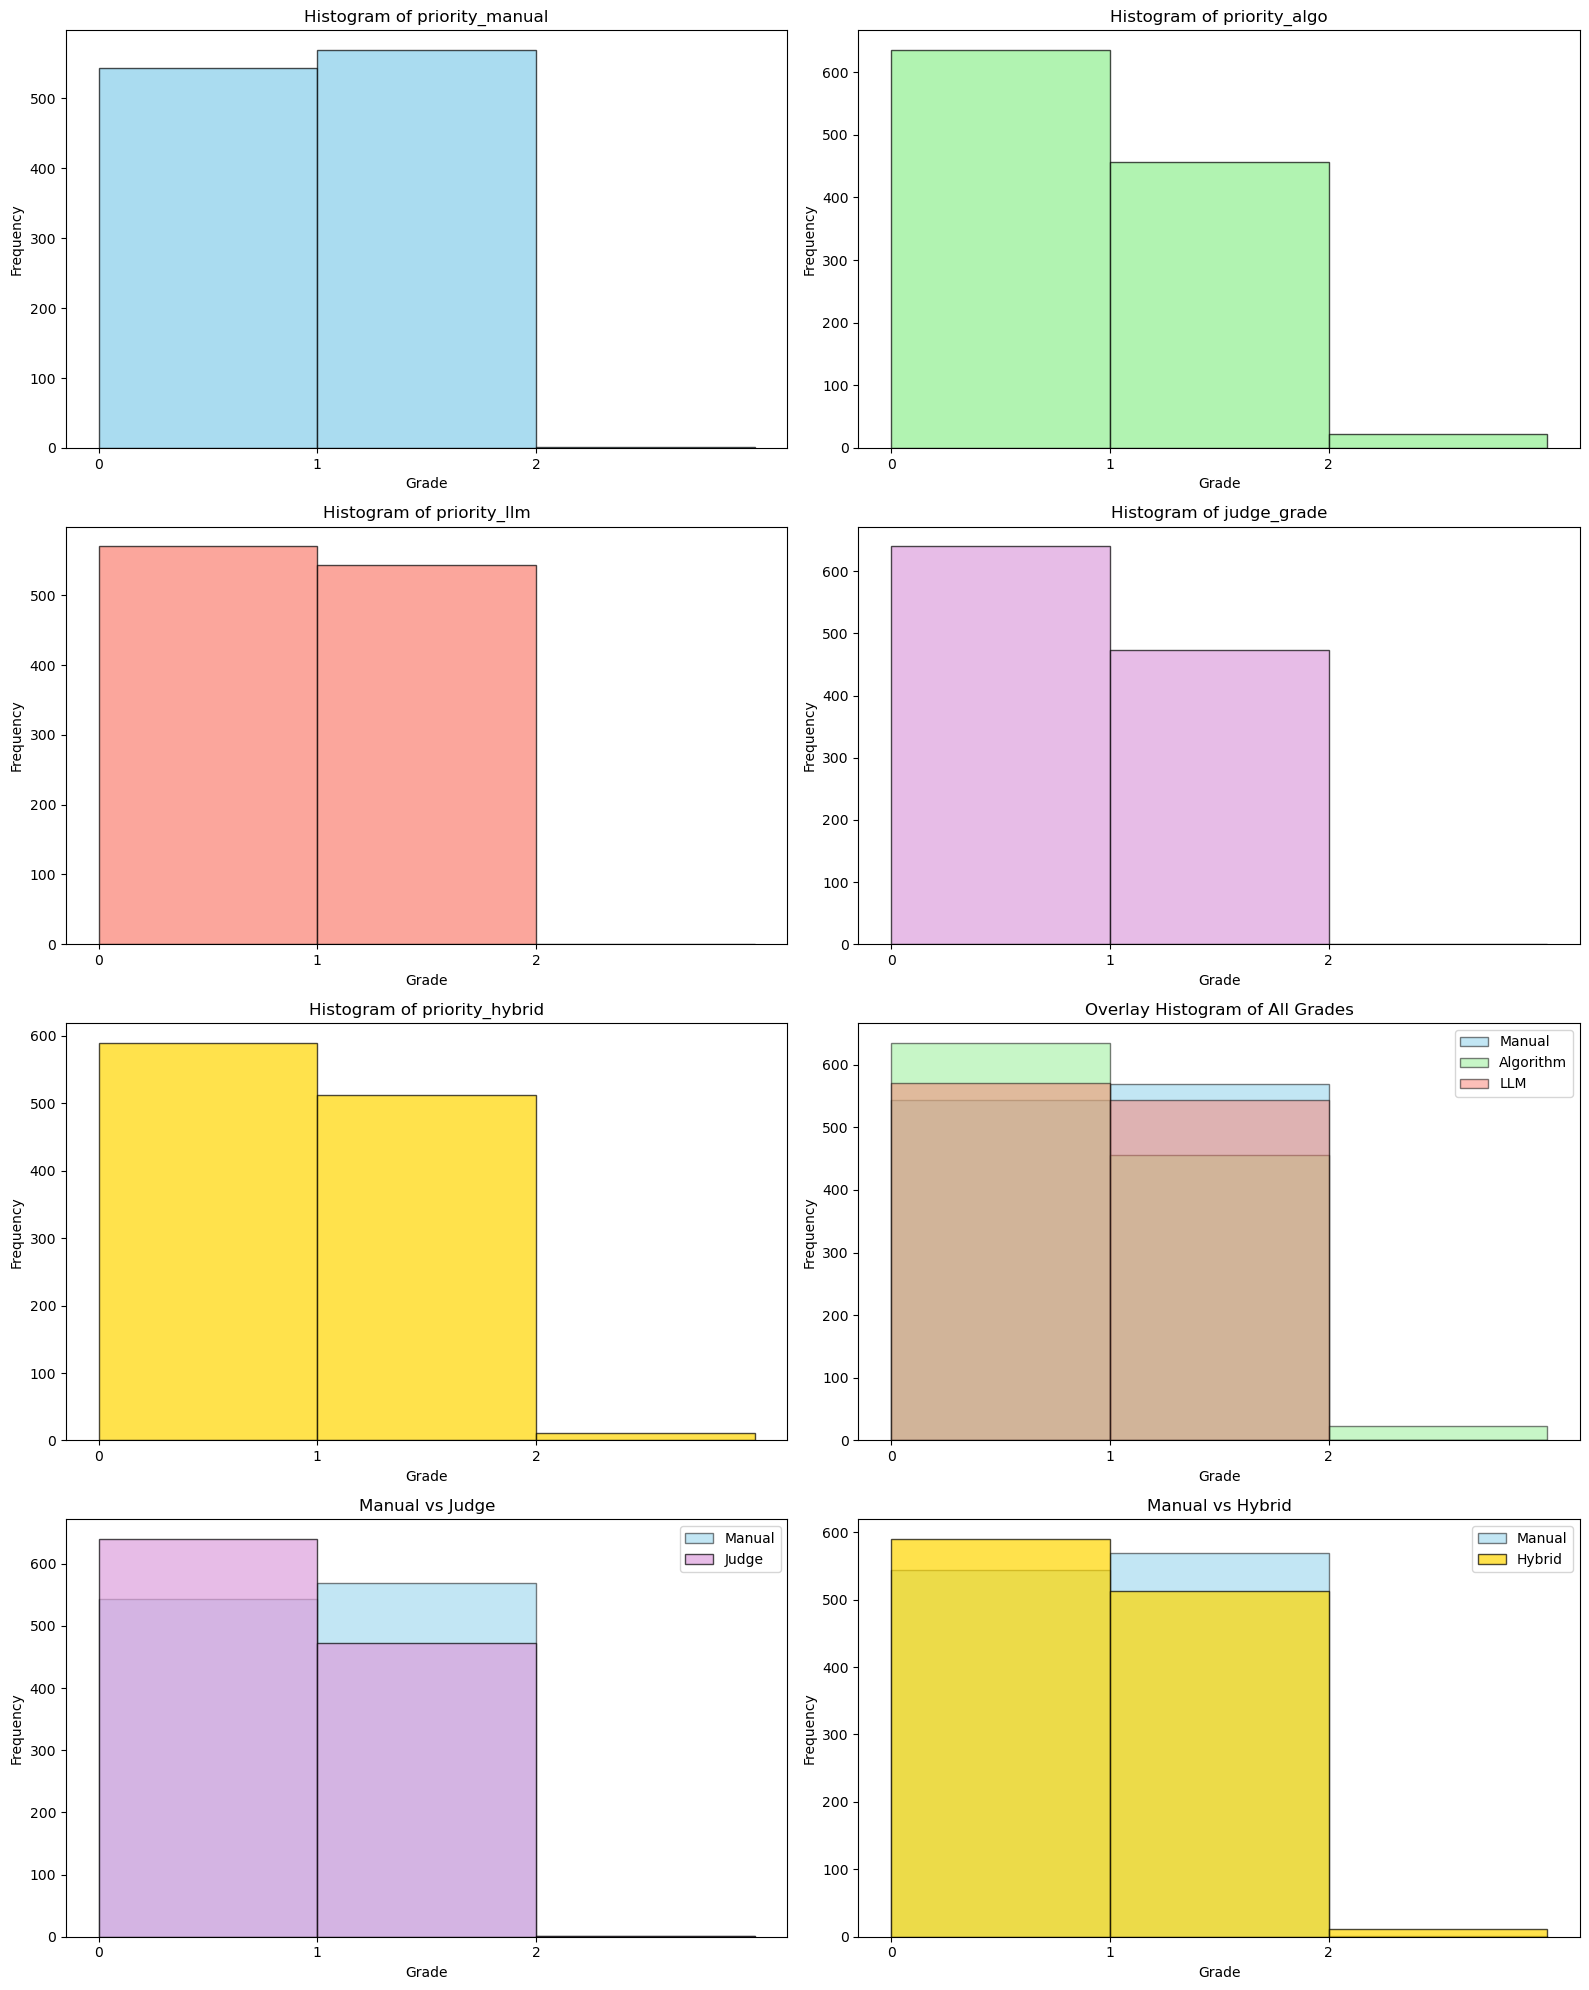

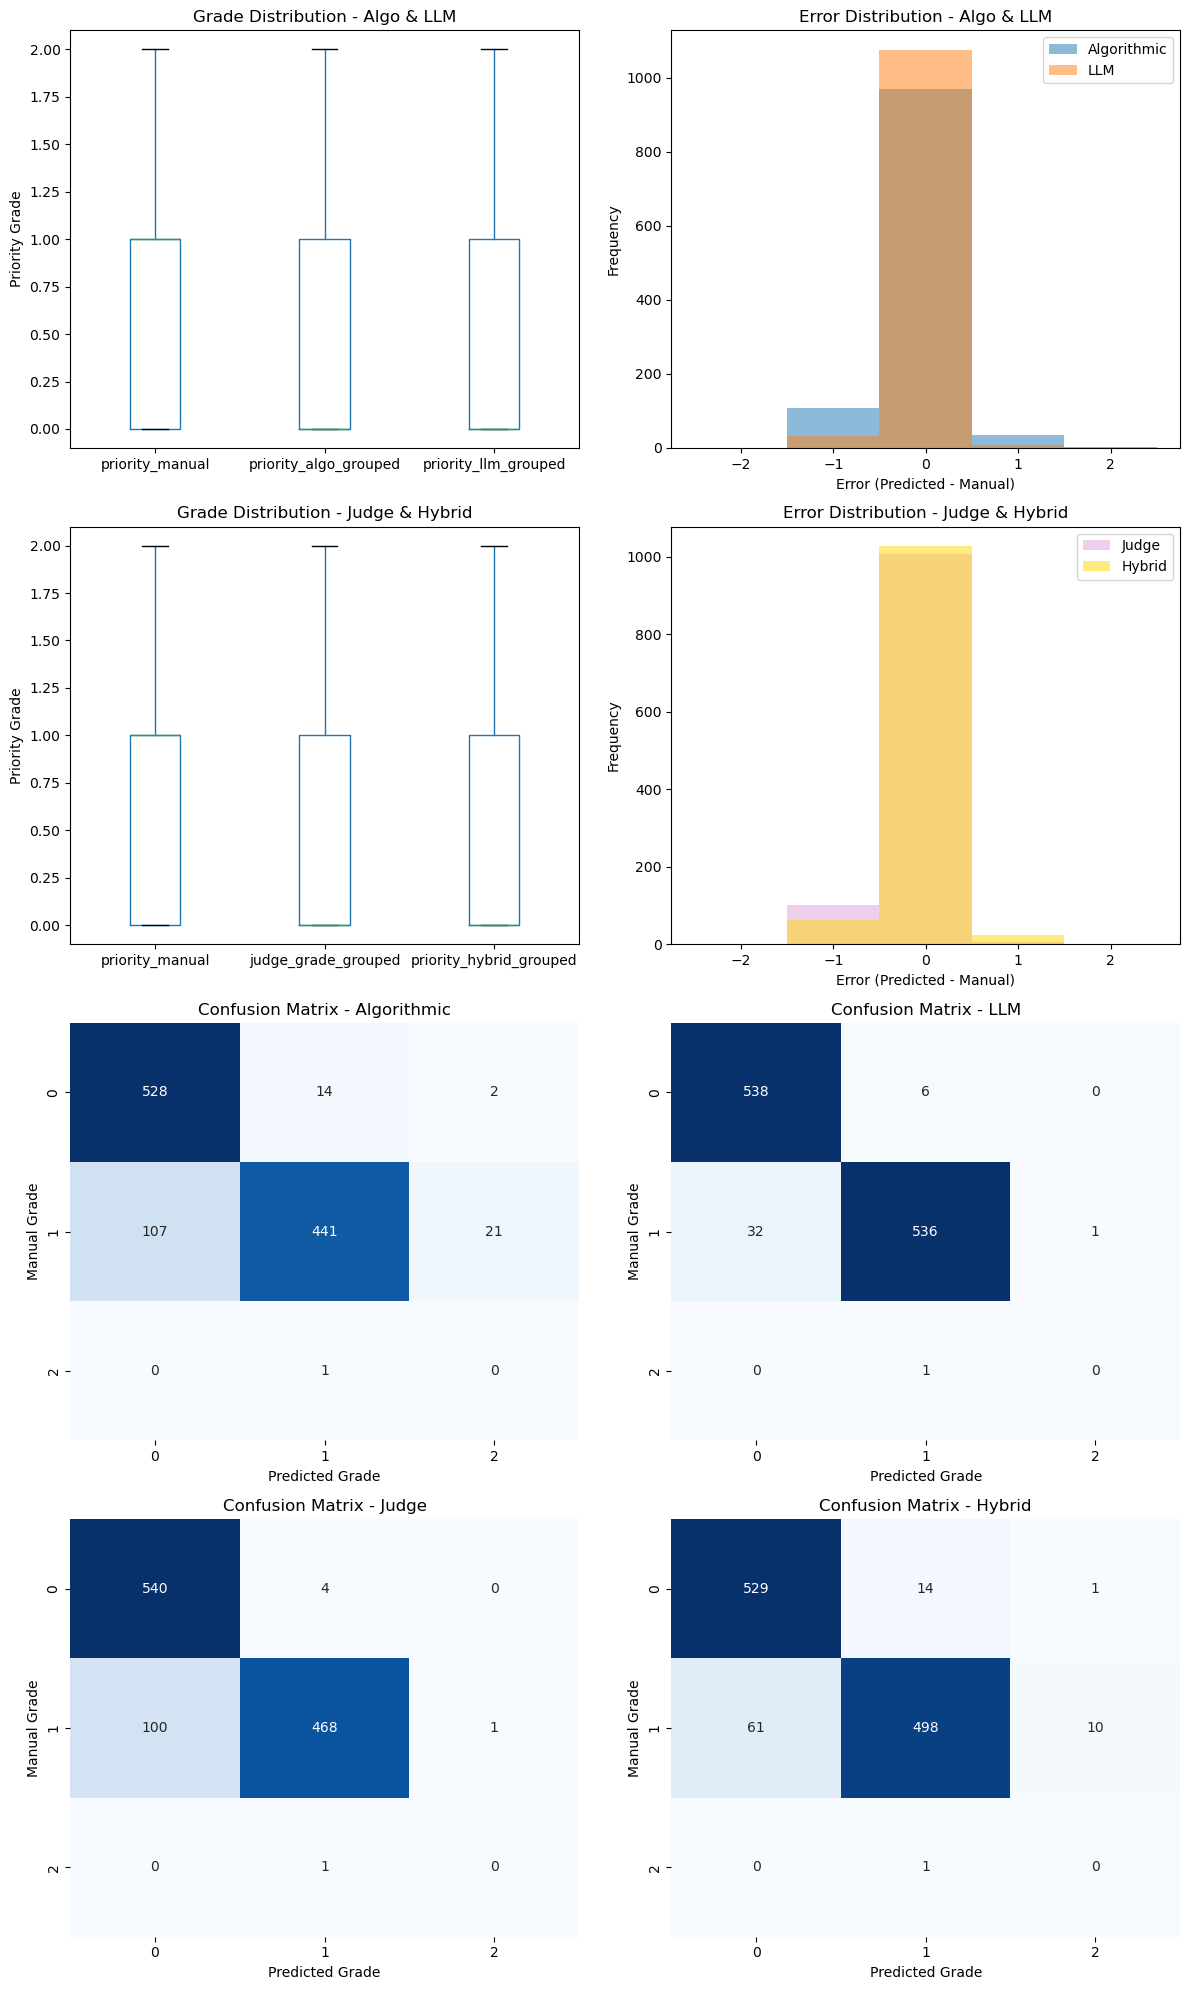

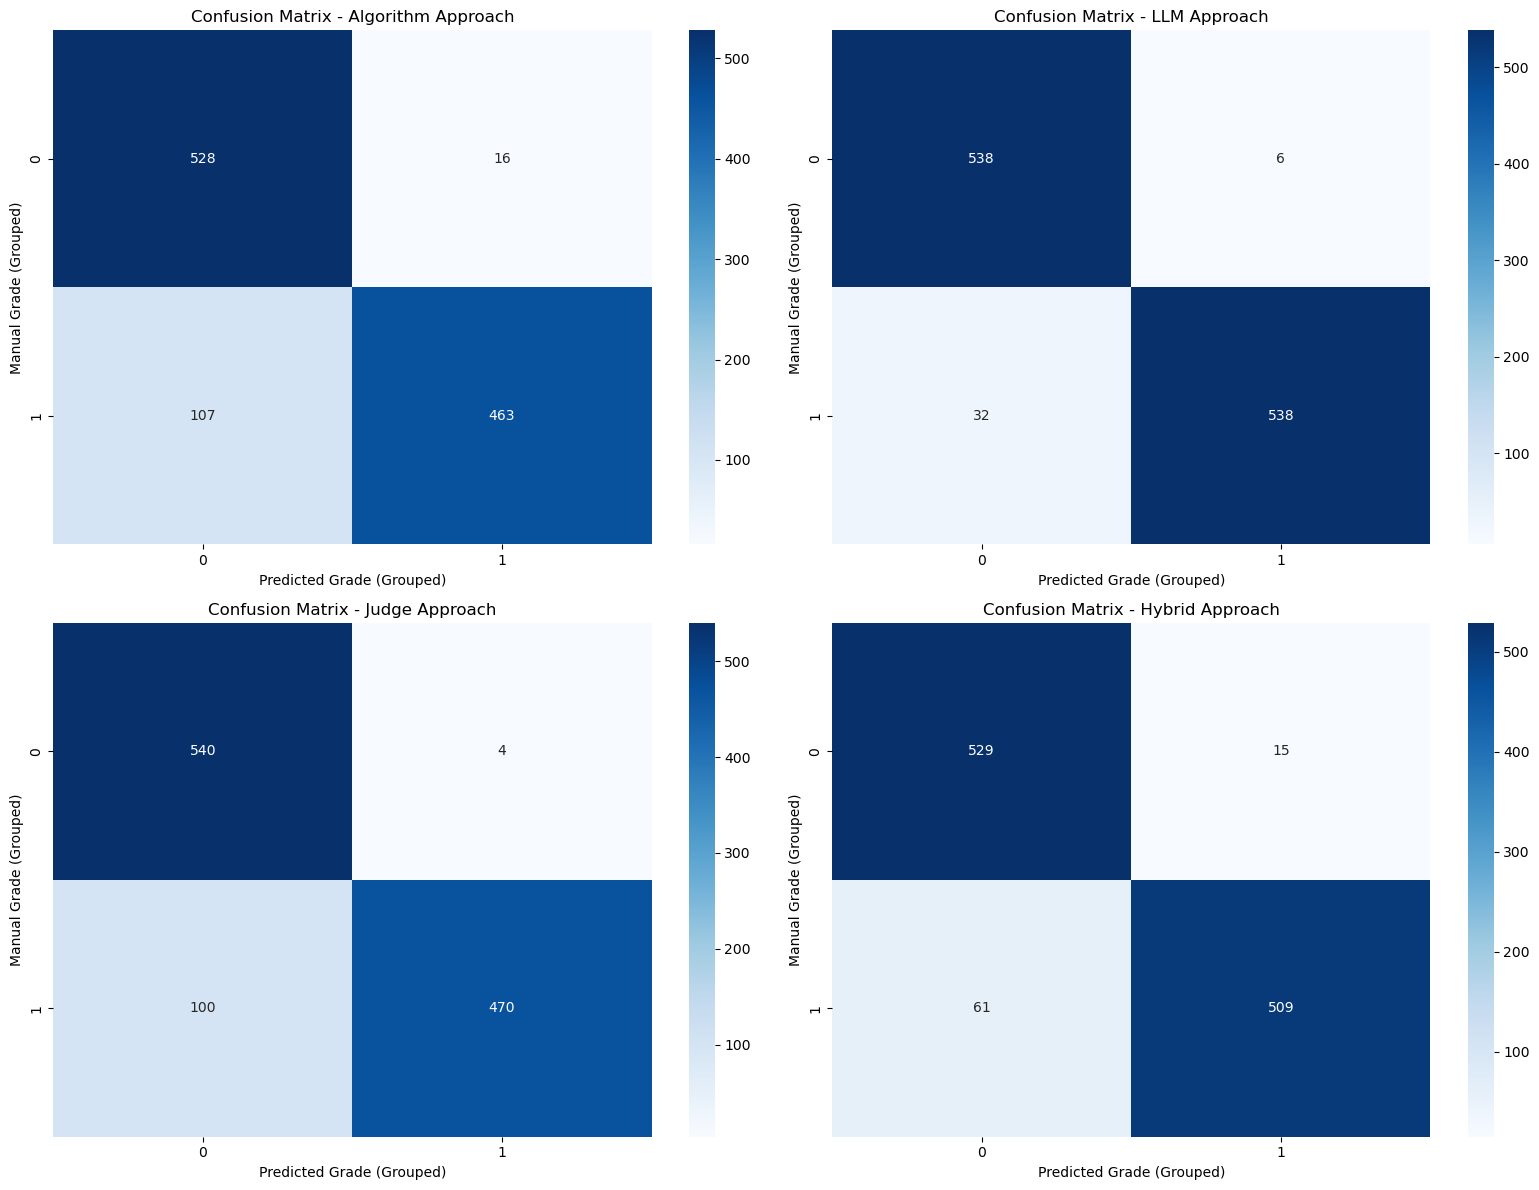

In [13]:
################################
### Visualization of Results ###
################################

# Plot histogram of priority_manual, priority_algo, priority_llm, judge_grade, and priority_hybrid
plt.figure(figsize=(16, 20))  # Made taller to accommodate additional plots

# Histogram for priority_manual
plt.subplot(4, 2, 1)
plt.hist(df_reports_overall['priority_manual'], bins=range(0, 4), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_manual')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))

# Histogram for priority_algo
plt.subplot(4, 2, 2)
plt.hist(df_reports_overall['priority_algo_grouped'], bins=range(0, 4), color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_algo')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))

# Histogram for priority_llm
plt.subplot(4, 2, 3)
plt.hist(df_reports_overall['priority_llm_grouped'], bins=range(0, 4), color='salmon', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_llm')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))

# Histogram for judge_grade
plt.subplot(4, 2, 4)
plt.hist(df_reports_overall['judge_grade_grouped'], bins=range(0, 4), color='plum', edgecolor='black', alpha=0.7)
plt.title('Histogram of judge_grade')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))

# Histogram for priority_hybrid
plt.subplot(4, 2, 5)
plt.hist(df_reports_overall['priority_hybrid_grouped'], bins=range(0, 4), color='gold', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_hybrid')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))

# Overlay histogram of all grades
plt.subplot(4, 2, 6)
plt.hist(df_reports_overall['priority_manual'], bins=range(0, 4), color='skyblue', edgecolor='black', alpha=0.5, label='Manual')
plt.hist(df_reports_overall['priority_algo_grouped'], bins=range(0, 4), color='lightgreen', edgecolor='black', alpha=0.5, label='Algorithm')
plt.hist(df_reports_overall['priority_llm_grouped'], bins=range(0, 4), color='salmon', edgecolor='black', alpha=0.5, label='LLM')
#plt.hist(df_reports_overall['priority_hybrid_grouped'], bins=range(0, 4), color='gold', edgecolor='black', alpha=0.5, label='Hybrid')
plt.title('Overlay Histogram of All Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))
plt.legend()

# Overlay histogram of manual vs judge
plt.subplot(4, 2, 7)
plt.hist(df_reports_overall['priority_manual'], bins=range(0, 4), color='skyblue', edgecolor='black', alpha=0.5, label='Manual')
plt.hist(df_reports_overall['judge_grade_grouped'], bins=range(0, 4), color='plum', edgecolor='black', alpha=0.7, label='Judge')
plt.title('Manual vs Judge')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))
plt.legend()

# Overlay histogram of manual vs hybrid
plt.subplot(4, 2, 8)
plt.hist(df_reports_overall['priority_manual'], bins=range(0, 4), color='skyblue', edgecolor='black', alpha=0.5, label='Manual')
plt.hist(df_reports_overall['priority_hybrid_grouped'], bins=range(0, 4), color='gold', edgecolor='black', alpha=0.7, label='Hybrid')
plt.title('Manual vs Hybrid')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(0, 3))
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of results
plt.figure(figsize=(12, 20))

# Helper function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=range(0, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted Grade')
    ax.set_ylabel('Manual Grade')
    ax.set_xticks(np.arange(3) + 0.5, range(0, 3))
    ax.set_yticks(np.arange(3) + 0.5, range(0, 3))
    ax.set_xticklabels(range(0, 3))
    ax.set_yticklabels(range(0, 3))

# --- Row 1: Algo and LLM ---
# Box plot for Algo and LLM
ax1 = plt.subplot(4, 2, 1)
df_reports_overall[['priority_manual', 'priority_algo_grouped', 'priority_llm_grouped']].boxplot(ax=ax1)
ax1.set_title('Grade Distribution - Algo & LLM')
ax1.set_ylabel('Priority Grade')
ax1.grid(False)

# Error distribution for Algo and LLM
ax2 = plt.subplot(4, 2, 2)
error_algo = df_reports_overall['priority_algo_grouped'] - df_reports_overall['priority_manual']
error_llm = df_reports_overall['priority_llm_grouped'] - df_reports_overall['priority_manual']
ax2.hist(error_algo, alpha=0.5, bins=np.arange(-2.5, 3.5, 1), label='Algorithmic')
ax2.hist(error_llm, alpha=0.5, bins=np.arange(-2.5, 3.5, 1), label='LLM')
ax2.set_title('Error Distribution - Algo & LLM')
ax2.set_xlabel('Error (Predicted - Manual)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(False)

# --- Row 2: Judge and Hybrid ---
# Box plot for Judge and Hybrid
ax3 = plt.subplot(4, 2, 3)
df_reports_overall[['priority_manual', 'judge_grade_grouped', 'priority_hybrid_grouped']].boxplot(ax=ax3)
ax3.set_title('Grade Distribution - Judge & Hybrid')
ax3.set_ylabel('Priority Grade')
ax3.grid(False)

# Error distribution for Judge and Hybrid
ax4 = plt.subplot(4, 2, 4)
error_judge = df_reports_overall['judge_grade_grouped'] - df_reports_overall['priority_manual']
error_hybrid = df_reports_overall['priority_hybrid_grouped'] - df_reports_overall['priority_manual']
ax4.hist(error_judge, alpha=0.5, bins=np.arange(-2.5, 3.5, 1), label='Judge', color='plum')
ax4.hist(error_hybrid, alpha=0.5, bins=np.arange(-2.5, 3.5, 1), label='Hybrid', color='gold')
ax4.set_title('Error Distribution - Judge & Hybrid')
ax4.set_xlabel('Error (Predicted - Manual)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(False)

# --- Row 3: Confusion Matrices (Algo, LLM) ---
ax5 = plt.subplot(4, 2, 5)
plot_confusion_matrix(ax5, df_reports_overall['priority_manual'], 
                     df_reports_overall['priority_algo_grouped'], 'Confusion Matrix - Algorithmic')

ax6 = plt.subplot(4, 2, 6)
plot_confusion_matrix(ax6, df_reports_overall['priority_manual'], 
                     df_reports_overall['priority_llm_grouped'], 'Confusion Matrix - LLM')

# --- Row 4: Confusion Matrices (Judge, Hybrid) ---
ax7 = plt.subplot(4, 2, 7)
plot_confusion_matrix(ax7, df_reports_overall['priority_manual'], 
                     df_reports_overall['judge_grade_grouped'], 'Confusion Matrix - Judge')

ax8 = plt.subplot(4, 2, 8)
plot_confusion_matrix(ax8, df_reports_overall['priority_manual'], 
                     df_reports_overall['priority_hybrid_grouped'], 'Confusion Matrix - Hybrid')


plt.tight_layout()
plt.show()

# Confusion matrix for grouped grades
# Group grades 1 and 2 together for a binary classification (0 vs 1/2)
def group_grades(series):
    return series.replace({2: 1})

manual_grouped_binary = group_grades(df_reports_overall['priority_manual'])
algo_grouped_binary = group_grades(df_reports_overall['priority_algo_grouped'])
llm_grouped_binary = group_grades(df_reports_overall['priority_llm_grouped'])
judge_grouped_binary = group_grades(df_reports_overall['judge_grade_grouped'])
hybrid_grouped_binary = group_grades(df_reports_overall['priority_hybrid_grouped'])

# Calculate confusion matrices for the binary grouped grades
confusion_matrix_algo = confusion_matrix(manual_grouped_binary, algo_grouped_binary)
confusion_matrix_llm = confusion_matrix(manual_grouped_binary, llm_grouped_binary)
confusion_matrix_judge = confusion_matrix(manual_grouped_binary, judge_grouped_binary)
confusion_matrix_hybrid = confusion_matrix(manual_grouped_binary, hybrid_grouped_binary)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix_algo, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Algorithm Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix_llm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LLM Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.subplot(2, 2, 3)
sns.heatmap(confusion_matrix_judge, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Judge Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.subplot(2, 2, 4)
sns.heatmap(confusion_matrix_hybrid, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Hybrid Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.tight_layout()
plt.show()

In [6]:
####################
### Token Counts ###
####################

# Token counting
import tiktoken

def count_tokens(prompt, model="gpt-3.5-turbo"):
    # Retrieve the encoding for the model. Adjust the model name if needed.
    encoding = tiktoken.encoding_for_model(model)
    tokens = encoding.encode(prompt)
    return len(tokens)

print('The semi-algorithmic approach uses ~1500 tokens')
print('The LLM approach uses ~650 tokens')

The semi-algorithmic approach uses ~1500 tokens
The LLM approach uses ~650 tokens
